# ET-287 - Processamento de sinais usando redes neurais

_Aluno: Denys Derlian Carvalho Brito_

---

## Projeto Exame - Classificação de Desempenho em Criptografia Quântica com Redes Neurais Profundas

**Objetivo:** Desenvolver um classificador baseado em redes neurais profundas capaz de prever, a partir de variáveis heterogêneas de um ambiente de criptografia quântica, a classe de desempenho (“Ótimo” vs. “Subótimo”) com alta acurácia e boa capacidade de generalização.


No contexto da computação quântica, a criptografia quântica oferece novos paradigmas de segurança baseados em princípios de mecânica quântica. Sob essa perspectiva, a aplicação de técnicas de aprendizado de máquina tem sido explorada para otimizar e aprimorar o desempenho dos sistemas de criptografia quântica. Todavia, a complexidade inerente a esses sistemas, aliada à heterogeneidade dos dados gerados, impõe desafios significativos para a construção de modelos preditivos eficazes. Nesse cenário, propõe uma abordagem que foca na classificação da **performance da rede** de forma integrada, considerando não apenas os parâmetros quânticos e de segurança, mas também métricas de performance de rede, características de _big data_ e utilização de recursos computacionais, que em conjunto determinam a viabilidade prática dos sistema em cenários operacionais reais.

---

## 4. Criar um modelo mais complexo com mecanismos de atenção e arquiteturas paralelas. 

_A ideia dessa arquitetura é explorar as correlações positivas e negativas entre diferentes subconjuntos de variáveis, permitindo que o modelo aprenda representações mais ricas e contextuais dos dados. Também, foram adicionados mecanismos de atenção para que o modelo possa focar nas partes mais relevantes dos dados de entrada, melhorando a capacidade de capturar relações complexas entre as variáveis._

In [1]:
# Importart bibliotecas a partir do módulo config
from modules.config import *

/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-18 22:13:05.210611: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-18 22:13:05.256301: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-18 22:13:06.959886: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see sl

Num GPUs Available:  1


In [2]:
# Carregar os dados pre-processados
df_preprocessed = pd.read_csv("./data/preprocessed/df_preprocessed.csv")
X_numerical_df = pd.read_csv("./data/preprocessed/X_numerical_preprocessed.csv")
X_categorical_df = pd.read_csv("./data/preprocessed/X_categorical_preprocessed.csv")
y = pd.read_csv("./data/preprocessed/y_preprocessed.csv")


TARGET_VARIABLE = 'Performance_Target'
CATEGORICAL_COLUMNS = df_preprocessed.select_dtypes(include=['object', 'category']).columns.tolist()
NUMERICAL_COLUMNS = df_preprocessed.select_dtypes(include=['number']).columns.difference([TARGET_VARIABLE]).tolist()

In [3]:
# Definir Focal Loss (binary) com alpha balanceado
def binary_focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss para classificação binária.
    
    Args:
        gamma: foco em exemplos difíceis (quanto maior, mais foco)
        alpha: peso para classe 1 (positiva)
    """
    def loss_fn(y_true, y_pred):
        # Converter para float32 para garantir compatibilidade
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Converter gamma e alpha para float32
        gamma_t = tf.constant(gamma, dtype=tf.float32)
        alpha_t_val = tf.constant(alpha, dtype=tf.float32)
        
        # clip y_pred para estabilidade numérica
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        
        # Calcular pt (probabilidade da classe verdadeira)
        pt = tf.where(tf.equal(y_true, 1.0), y_pred, 1.0 - y_pred)
        
        # Calcular alpha_t (peso balanceado)
        alpha_t = tf.where(tf.equal(y_true, 1.0), alpha_t_val, 1.0 - alpha_t_val)
        
        # Calcular focal loss
        loss = -alpha_t * tf.pow(1.0 - pt, gamma_t) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    
    return loss_fn

In [4]:
# Calcular alpha balanceado para a Focal Loss
class_counts = y.value_counts().sort_index()
n_samples = len(y)
n_classes = len(class_counts)
alpha_balanced = class_counts[0] / n_samples  # alpha para classe positiva (1)

print(f"Distribuição das classes:")
print(class_counts)
print(f"\nAlpha balanceado para Focal Loss: {alpha_balanced:.4f}")

# Calcular cardinalidades das variáveis categóricas
categorical_cardinalities = {}
for col in X_categorical_df.columns:
    categorical_cardinalities[col] = X_categorical_df[col].nunique() + 1  # +1 para possível valor desconhecido

print(f"\nCardinalidades das variáveis categóricas:")
for col, card in categorical_cardinalities.items():
    print(f"  {col}: {card}")

# Definir grupos de variáveis por correlação com target
NUMERIC_POSITIVE_CORR = [
    'Throughput_Mbps', 'Bandwidth_Utilization_percent', 
    'Resource_Utilization_CPU_percent', 'Round_Trip_Time_ms', 'Data_Velocity_MB_s', 
    'Resource_Utilization_Memory_percent', 'Security_Index', 'Latency_Efficiency', 
    'Energy_per_Throughput'
]

NUMERIC_NEGATIVE_CORR = [
    'Energy_Consumption_kWh', 'Data_Volume_GB', 
    'Packet_Loss_percent', 'Intrusion_Detection_Accuracy_percent', 'Decryption_Latency_ms', 
    'Latency_ms', 'Encryption_Latency_ms', 'Attack_Success_Rate_percent', 'Latency_mean'
]

CATEGORICAL_POSITIVE_CORR = ['Optimization_Level', 'Data_Variety', 'Attack_Type']

CATEGORICAL_NEGATIVE_CORR = [col for col in X_categorical_df.columns 
                              if col not in CATEGORICAL_POSITIVE_CORR]

print(f"\n=== Grupos de Variáveis por Correlação ===")
print(f"\nNuméricas com correlação positiva ({len(NUMERIC_POSITIVE_CORR)}):")
print(f"  {NUMERIC_POSITIVE_CORR}")
print(f"\nNuméricas com correlação negativa ({len(NUMERIC_NEGATIVE_CORR)}):")
print(f"  {NUMERIC_NEGATIVE_CORR}")
print(f"\nCategóricas com correlação positiva ({len(CATEGORICAL_POSITIVE_CORR)}):")
print(f"  {CATEGORICAL_POSITIVE_CORR}")
print(f"\nCategóricas com correlação negativa ({len(CATEGORICAL_NEGATIVE_CORR)}):")
print(f"  {CATEGORICAL_NEGATIVE_CORR}")

Distribuição das classes:
Performance_Target
0                     918
1                      82
Name: count, dtype: int64

Alpha balanceado para Focal Loss: 0.9180

Cardinalidades das variáveis categóricas:
  Quantum_Key_Size_bits: 5
  Quantum_Protocol_Type: 5
  Key_Distribution_Method: 4
  Encryption_Strength: 4
  Attack_Type: 5
  Vulnerability_Level: 5
  Data_Variety: 5
  Data_Complexity: 4
  Real_Time_Processing: 3
  Optimization_Level: 5

=== Grupos de Variáveis por Correlação ===

Numéricas com correlação positiva (9):
  ['Throughput_Mbps', 'Bandwidth_Utilization_percent', 'Resource_Utilization_CPU_percent', 'Round_Trip_Time_ms', 'Data_Velocity_MB_s', 'Resource_Utilization_Memory_percent', 'Security_Index', 'Latency_Efficiency', 'Energy_per_Throughput']

Numéricas com correlação negativa (9):
  ['Energy_Consumption_kWh', 'Data_Volume_GB', 'Packet_Loss_percent', 'Intrusion_Detection_Accuracy_percent', 'Decryption_Latency_ms', 'Latency_ms', 'Encryption_Latency_ms', 'Attack_Success_

In [5]:
def soft_attention_layer(x, d_model, attention_units, name_prefix):
    """
    Mecanismo de atenção soft verdadeiro.
    Cada feature atende a todas as outras features através de Query-Key-Value.
    
    Args:
        x: tensor de entrada (batch_size, d_model)
        d_model: dimensão do vetor de features
        attention_units: unidades intermediárias para calcular scores
        name_prefix: prefixo para nomear camadas
    
    Returns:
        tensor com atenção aplicada (batch_size, d_model)
    """
    # Expandir dimensões: (batch, d_model) -> (batch, d_model, 1)
    x_expanded = layers.Reshape((d_model, 1), name=f'{name_prefix}_reshape_in')(x)
    
    # Calcular queries, keys e values
    queries = layers.Conv1D(attention_units, 1, name=f'{name_prefix}_queries')(x_expanded)
    keys = layers.Conv1D(attention_units, 1, name=f'{name_prefix}_keys')(x_expanded)
    values = layers.Conv1D(attention_units, 1, name=f'{name_prefix}_values')(x_expanded)
    
    # Calcular scores de atenção: Q @ K^T
    # (batch, d_model, attention_units) @ (batch, attention_units, d_model)
    attention_scores = layers.Lambda(
        lambda qk: tf.matmul(qk[0], qk[1], transpose_b=True),
        output_shape=(d_model, d_model),
        name=f'{name_prefix}_scores'
    )([queries, keys])
    
    # Escalar por sqrt(attention_units)
    scale_factor = tf.sqrt(tf.cast(attention_units, tf.float32))
    attention_scores = layers.Lambda(
        lambda x_in: x_in / scale_factor,
        output_shape=(d_model, d_model),
        name=f'{name_prefix}_scaled_scores'
    )(attention_scores)
    
    # Aplicar softmax: (batch, d_model, d_model)
    attention_weights = layers.Softmax(name=f'{name_prefix}_attention_weights')(attention_scores)
    
    # Aplicar atenção aos valores
    # (batch, d_model, d_model) @ (batch, d_model, attention_units) = (batch, d_model, attention_units)
    attended = layers.Lambda(
        lambda aw_v: tf.matmul(aw_v[0], aw_v[1]),
        output_shape=(d_model, attention_units),
        name=f'{name_prefix}_attended'
    )([attention_weights, values])
    
    # Projeção de volta para d_model
    attended = layers.Conv1D(1, 1, name=f'{name_prefix}_project')(attended)
    
    # Reshape: (batch, d_model, 1) -> (batch, d_model)
    attended = layers.Reshape((d_model,), name=f'{name_prefix}_reshape_out')(attended)
    
    # Residual connection + Layer Normalization
    output = layers.Add(name=f'{name_prefix}_residual')([x, attended])
    output = layers.LayerNormalization(epsilon=1e-6, name=f'{name_prefix}_layernorm')(output)
    
    return output


def build_multiheaded_attention(
    n_numeric_pos, 
    n_numeric_neg,
    categorical_cardinalities_pos,
    categorical_cardinalities_neg,
    numeric_layers=[64, 32], 
    categorical_layers=[32, 16],
    attention_units=32,
    merged_layers=[128, 64],
    activation='relu',
    lr=1e-3, 
    l2_reg=1e-5, 
    dropout_rate=0.3,
    focal_gamma=2.0,
    focal_alpha=0.25,
    use_true_attention=True  # Novo parâmetro para escolher entre atenção real ou gating
):
    """
    Arquitetura com múltiplos ramos paralelos baseados em correlação com target.
    Cada ramo (numérico pos/neg e categórico pos/neg) é processado separadamente
    e passa por um mecanismo de atenção antes da fusão final.
    
    Args:
        n_numeric_pos: número de features numéricas com correlação positiva
        n_numeric_neg: número de features numéricas com correlação negativa
        categorical_cardinalities_pos: dict com cardinalidade das categóricas positivas
        categorical_cardinalities_neg: dict com cardinalidade das categóricas negativas
        numeric_layers: lista com neurônios para camadas numéricas
        categorical_layers: lista com neurônios para camadas categóricas (após embeddings)
        attention_units: número de unidades para o mecanismo de atenção
        merged_layers: lista com neurônios para camadas após fusão
        activation: função de ativação
        lr: learning rate
        l2_reg: regularização L2
        dropout_rate: taxa de dropout
        focal_gamma: parâmetro gamma da focal loss
        focal_alpha: parâmetro alpha da focal loss
        use_true_attention: True para atenção real, False para feature gating simples
    """
    inputs = []
    branches = []
    
    # ==================== RAMO NUMÉRICO POSITIVO ====================
    if n_numeric_pos > 0:
        numeric_pos_input = layers.Input(shape=(n_numeric_pos,), name='numeric_pos_input')
        x_pos = layers.BatchNormalization(name='bn_numeric_pos')(numeric_pos_input)
        
        for i, units in enumerate(numeric_layers):
            x_pos = layers.Dense(units, kernel_regularizer=regularizers.l2(l2_reg), 
                                name=f'numeric_pos_dense_{i}')(x_pos)
            x_pos = layers.Activation(activation)(x_pos)
            if i < len(numeric_layers) - 1:
                x_pos = layers.Dropout(dropout_rate)(x_pos)
        
        # Aplicar mecanismo de atenção ou gating
        if use_true_attention:
            # ATENÇÃO REAL: features interagem entre si
            x_pos = soft_attention_layer(
                x_pos, 
                d_model=numeric_layers[-1],
                attention_units=attention_units,
                name_prefix='numeric_pos'
            )
        else:
            # FEATURE GATING: cada feature é modulada independentemente
            x_pos_gate = layers.Dense(attention_units, activation='tanh', 
                                     name='numeric_pos_gate_hidden')(x_pos)
            x_pos_gate = layers.Dense(numeric_layers[-1], activation='sigmoid', 
                                     name='numeric_pos_gate')(x_pos_gate)
            x_pos = layers.Multiply(name='numeric_pos_gated')([x_pos, x_pos_gate])
        
        branches.append(x_pos)
        inputs.append(numeric_pos_input)
    
    # ==================== RAMO NUMÉRICO NEGATIVO ====================
    if n_numeric_neg > 0:
        numeric_neg_input = layers.Input(shape=(n_numeric_neg,), name='numeric_neg_input')
        x_neg = layers.BatchNormalization(name='bn_numeric_neg')(numeric_neg_input)
        
        for i, units in enumerate(numeric_layers):
            x_neg = layers.Dense(units, kernel_regularizer=regularizers.l2(l2_reg), 
                                name=f'numeric_neg_dense_{i}')(x_neg)
            x_neg = layers.Activation(activation)(x_neg)
            if i < len(numeric_layers) - 1:
                x_neg = layers.Dropout(dropout_rate)(x_neg)
        
        # Aplicar mecanismo de atenção ou gating
        if use_true_attention:
            x_neg = soft_attention_layer(
                x_neg,
                d_model=numeric_layers[-1],
                attention_units=attention_units,
                name_prefix='numeric_neg'
            )
        else:
            x_neg_gate = layers.Dense(attention_units, activation='tanh', 
                                     name='numeric_neg_gate_hidden')(x_neg)
            x_neg_gate = layers.Dense(numeric_layers[-1], activation='sigmoid', 
                                     name='numeric_neg_gate')(x_neg_gate)
            x_neg = layers.Multiply(name='numeric_neg_gated')([x_neg, x_neg_gate])
        
        branches.append(x_neg)
        inputs.append(numeric_neg_input)
    
    # ==================== RAMO CATEGÓRICO POSITIVO ====================
    if len(categorical_cardinalities_pos) > 0:
        embedding_pos_outputs = []
        for col_name, card in categorical_cardinalities_pos.items():
            cat_input = layers.Input(shape=(1,), dtype='int32', name=f'cat_pos_in_{col_name}')
            emb_dim = min(50, max(2, int(card**0.25) + 1))
            embedding = layers.Embedding(input_dim=card, output_dim=emb_dim, 
                                        name=f'emb_pos_{col_name}')(cat_input)
            embedding = layers.Flatten()(embedding)
            embedding_pos_outputs.append(embedding)
            inputs.append(cat_input)
        
        # Concatenar embeddings positivos
        if len(embedding_pos_outputs) > 1:
            categorical_pos_concat = layers.Concatenate(name='concat_embeddings_pos')(embedding_pos_outputs)
        else:
            categorical_pos_concat = embedding_pos_outputs[0]
        
        # Processar através de MLP
        y_pos = categorical_pos_concat
        for i, units in enumerate(categorical_layers):
            y_pos = layers.Dense(units, kernel_regularizer=regularizers.l2(l2_reg), 
                                name=f'categorical_pos_dense_{i}')(y_pos)
            y_pos = layers.Activation(activation)(y_pos)
            if i < len(categorical_layers) - 1:
                y_pos = layers.Dropout(dropout_rate)(y_pos)
        
        # Aplicar mecanismo de atenção ou gating
        if use_true_attention:
            y_pos = soft_attention_layer(
                y_pos,
                d_model=categorical_layers[-1],
                attention_units=attention_units,
                name_prefix='categorical_pos'
            )
        else:
            y_pos_gate = layers.Dense(attention_units, activation='tanh', 
                                     name='categorical_pos_gate_hidden')(y_pos)
            y_pos_gate = layers.Dense(categorical_layers[-1], activation='sigmoid', 
                                     name='categorical_pos_gate')(y_pos_gate)
            y_pos = layers.Multiply(name='categorical_pos_gated')([y_pos, y_pos_gate])
        
        branches.append(y_pos)
    
    # ==================== RAMO CATEGÓRICO NEGATIVO ====================
    if len(categorical_cardinalities_neg) > 0:
        embedding_neg_outputs = []
        for col_name, card in categorical_cardinalities_neg.items():
            cat_input = layers.Input(shape=(1,), dtype='int32', name=f'cat_neg_in_{col_name}')
            emb_dim = min(50, max(2, int(card**0.25) + 1))
            embedding = layers.Embedding(input_dim=card, output_dim=emb_dim, 
                                        name=f'emb_neg_{col_name}')(cat_input)
            embedding = layers.Flatten()(embedding)
            embedding_neg_outputs.append(embedding)
            inputs.append(cat_input)
        
        # Concatenar embeddings negativos
        if len(embedding_neg_outputs) > 1:
            categorical_neg_concat = layers.Concatenate(name='concat_embeddings_neg')(embedding_neg_outputs)
        else:
            categorical_neg_concat = embedding_neg_outputs[0]
        
        # Processar através de MLP
        y_neg = categorical_neg_concat
        for i, units in enumerate(categorical_layers):
            y_neg = layers.Dense(units, kernel_regularizer=regularizers.l2(l2_reg), 
                                name=f'categorical_neg_dense_{i}')(y_neg)
            y_neg = layers.Activation(activation)(y_neg)
            if i < len(categorical_layers) - 1:
                y_neg = layers.Dropout(dropout_rate)(y_neg)
        
        # Aplicar mecanismo de atenção ou gating
        if use_true_attention:
            y_neg = soft_attention_layer(
                y_neg,
                d_model=categorical_layers[-1],
                attention_units=attention_units,
                name_prefix='categorical_neg'
            )
        else:
            y_neg_gate = layers.Dense(attention_units, activation='tanh', 
                                     name='categorical_neg_gate_hidden')(y_neg)
            y_neg_gate = layers.Dense(categorical_layers[-1], activation='sigmoid', 
                                     name='categorical_neg_gate')(y_neg_gate)
            y_neg = layers.Multiply(name='categorical_neg_gated')([y_neg, y_neg_gate])
        
        branches.append(y_neg)
    
    # ==================== FUSÃO E CAMADAS FINAIS ====================
    if len(branches) > 1:
        merged = layers.Concatenate(name='merge_all_branches')(branches)
    else:
        merged = branches[0]
    
    z = merged
    for i, units in enumerate(merged_layers):
        z = layers.Dense(units, kernel_regularizer=regularizers.l2(l2_reg), 
                        name=f'merged_dense_{i}')(z)
        z = layers.BatchNormalization()(z)
        z = layers.Activation(activation)(z)
        z = layers.Dropout(dropout_rate / 2)(z)
    
    output = layers.Dense(1, activation='sigmoid', name='output')(z)
    
    model = models.Model(inputs=inputs, outputs=output)
    
    # Compilar com Focal Loss
    loss_fn = binary_focal_loss(gamma=focal_gamma, alpha=focal_alpha)
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss=loss_fn,
        metrics=[
            tf.keras.metrics.AUC(name='roc_auc'),
            tf.keras.metrics.AUC(name='pr_auc', curve='PR')
        ]
    )
    
    return model

In [6]:
# Visualizar arquitetura do modelo com atenção multi-ramos (configuração padrão)

# Separar cardinalidades por correlação
categorical_cardinalities_pos = {k: v for k, v in categorical_cardinalities.items() 
                                 if k in CATEGORICAL_POSITIVE_CORR}
categorical_cardinalities_neg = {k: v for k, v in categorical_cardinalities.items() 
                                 if k in CATEGORICAL_NEGATIVE_CORR}

model_view = build_multiheaded_attention(
    n_numeric_pos=len(NUMERIC_POSITIVE_CORR),
    n_numeric_neg=len(NUMERIC_NEGATIVE_CORR),
    categorical_cardinalities_pos=categorical_cardinalities_pos,
    categorical_cardinalities_neg=categorical_cardinalities_neg,
    numeric_layers=[64, 32],
    categorical_layers=[32, 16],
    attention_units=32,
    merged_layers=[128, 64],
    focal_alpha=alpha_balanced
)
model_view.summary()

I0000 00:00:1763514796.114508    3871 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cat_pos_in_Attack_… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_pos_in_Data_Va… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_pos_in_Optimiz… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_neg_in_Quantum… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_neg_in_Quantum… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_neg_in_Key_Dis… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_neg_in_Encrypt… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_neg_in_Vulnera… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_neg_in_Data_Co… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_neg_in_Real_Ti… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_pos_Attack_Type │ (None, 1, 2)      │         10 │ cat_pos_in_Attac… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_pos_Data_Varie… │ (None, 1, 2)      │         10 │ cat_pos_in_Data_… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_pos_Optimizati… │ (None, 1, 2)      │         10 │ cat_pos_in_Optim… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_neg_Quantum_Ke… │ (None, 1, 2)      │         10 │ cat_neg_in_Quant… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_neg_Quantum_Pr… │ (None, 1, 2)      │         10 │ cat_neg_in_Quant… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_neg_Key_Distri… │ (None, 1, 2)      │          8 │ cat_neg_in_Key_D… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_neg_Encryption… │ (None, 1, 2)      │          8 │ cat_neg_in_Encry

 Total params: 29,959 (117.03 KB)

 Trainable params: 29,539 (115.39 KB)

 Non-trainable params: 420 (1.64 KB)

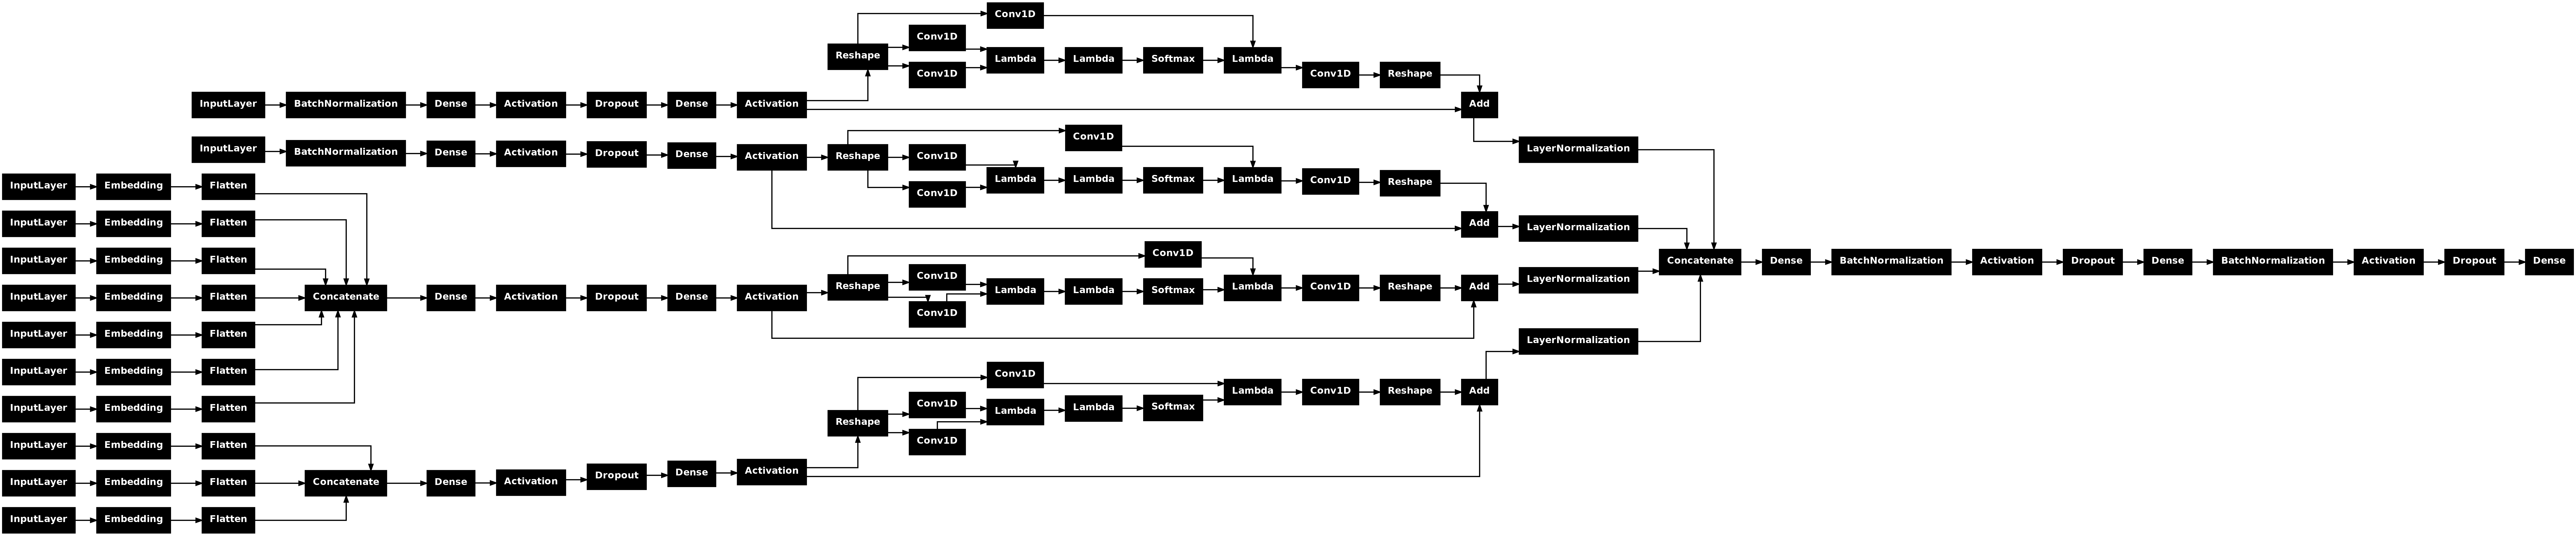

In [8]:
model_view_plot = tf.keras.utils.plot_model(model_view, show_shapes=False, dpi=200, expand_nested=False, rankdir='LR')
model_view_plot

In [8]:
tf.keras.backend.clear_session()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

metrics = {
    'roc_auc': [], 'pr_auc': [], 'f1': [], 'precision': [], 'recall': [], 'accuracy': [], 'conf_mat': []
}

for fold, (train_idx, val_idx) in enumerate(skf.split(X_numerical_df, y), 1):
    print(f"\n--- Fold {fold} ---")
    
    # Separar dados numéricos por correlação
    X_num_train_raw = X_numerical_df.iloc[train_idx]
    X_num_val_raw = X_numerical_df.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx].values.ravel(), y.iloc[val_idx].values.ravel()

    # Separar os dados categóricos
    X_cat_train = X_categorical_df.iloc[train_idx]
    X_cat_val = X_categorical_df.iloc[val_idx]

    # Fit scaler apenas no treino (evita data leakage)
    scaler_fold = MinMaxScaler()
    X_num_train_pos = scaler_fold.fit_transform(X_num_train_raw[NUMERIC_POSITIVE_CORR])
    X_num_val_pos = scaler_fold.transform(X_num_val_raw[NUMERIC_POSITIVE_CORR])
    
    X_num_train_neg = scaler_fold.fit_transform(X_num_train_raw[NUMERIC_NEGATIVE_CORR])
    X_num_val_neg = scaler_fold.transform(X_num_val_raw[NUMERIC_NEGATIVE_CORR])
    
    # Calcular alpha balanceado por fold
    class_counts_fold = pd.Series(y_train).value_counts().sort_index()
    alpha_fold = class_counts_fold[0] / len(y_train)
    
    # Calcular class weights por fold (não global)
    class_weights_values = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_fold = dict(enumerate(class_weights_values))
    print(f"Class weights para fold {fold}: {class_weight_fold}")
    print(f"Alpha focal loss: {alpha_fold:.4f}")

    # Modelo com atenção multi-ramos com configuração padrão
    model = build_multiheaded_attention(
        n_numeric_pos=len(NUMERIC_POSITIVE_CORR),
        n_numeric_neg=len(NUMERIC_NEGATIVE_CORR),
        categorical_cardinalities_pos=categorical_cardinalities_pos,
        categorical_cardinalities_neg=categorical_cardinalities_neg,
        numeric_layers=[64, 32],
        categorical_layers=[32, 16],
        attention_units=32,
        merged_layers=[128, 64],
        activation='relu',
        lr=1e-3,
        l2_reg=1e-5,
        dropout_rate=0.3,
        focal_gamma=2.0,
        focal_alpha=alpha_fold
    )

    # Preparar inputs para o modelo (separados por correlação)
    X_train_inputs = [X_num_train_pos, X_num_train_neg]
    X_train_inputs += [X_cat_train[col].values.reshape(-1, 1) for col in CATEGORICAL_POSITIVE_CORR]
    X_train_inputs += [X_cat_train[col].values.reshape(-1, 1) for col in CATEGORICAL_NEGATIVE_CORR]
    
    X_val_inputs = [X_num_val_pos, X_num_val_neg]
    X_val_inputs += [X_cat_val[col].values.reshape(-1, 1) for col in CATEGORICAL_POSITIVE_CORR]
    X_val_inputs += [X_cat_val[col].values.reshape(-1, 1) for col in CATEGORICAL_NEGATIVE_CORR]

    # Callbacks
    model_checkpoint = callbacks.ModelCheckpoint(
        filepath=f'./models/attention_mlp_fold{fold}.keras',
        monitor='val_pr_auc',
        mode='max',
        save_best_only=True,
        verbose=0
    )
    es = callbacks.EarlyStopping(monitor='val_pr_auc', patience=10, mode='max', restore_best_weights=True, verbose=0)
    rl = callbacks.ReduceLROnPlateau(monitor='val_pr_auc', factor=0.5, patience=6, mode='max', verbose=0)

    model.fit(
        X_train_inputs, y_train,
        validation_data=(X_val_inputs, y_val),
        epochs=100,
        batch_size=32,
        class_weight=class_weight_fold,
        callbacks=[es, rl, model_checkpoint],
        verbose=0
    )

    # Previsões e métricas
    y_pred_prob = model.predict(X_val_inputs, verbose=0).ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    roc = roc_auc_score(y_val, y_pred_prob)
    pr = average_precision_score(y_val, y_pred_prob)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    acc = accuracy_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)

    print(f"ROC-AUC: {roc:.4f}  PR-AUC: {pr:.4f}  F1: {f1:.4f}  Prec: {prec:.4f}  Rec: {rec:.4f}  Acc: {acc:.4f}")
    print("Conf matrix:\n", cm)

    metrics['roc_auc'].append(roc)
    metrics['pr_auc'].append(pr)
    metrics['f1'].append(f1)
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['accuracy'].append(acc)
    metrics['conf_mat'].append(cm)
    
    tf.keras.backend.clear_session()


--- Fold 1 ---
Class weights para fold 1: {0: 0.5449591280653951, 1: 6.0606060606060606}
Alpha focal loss: 0.9175


2025-11-09 23:21:50.725105: I external/local_xla/xla/service/service.cc:163] XLA service 0x714300007200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-09 23:21:50.725130: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-11-09 23:21:50.951097: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-09 23:21:50.951097: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-09 23:21:51.958775: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-11-09 23:21:51.958775: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-11-09 23:21:52.466802: I externa

ROC-AUC: 0.9885  PR-AUC: 0.8657  F1: 0.7429  Prec: 0.6842  Rec: 0.8125  Acc: 0.9550
Conf matrix:
 [[178   6]
 [  3  13]]

--- Fold 2 ---
Class weights para fold 2: {0: 0.5449591280653951, 1: 6.0606060606060606}
Alpha focal loss: 0.9175
ROC-AUC: 0.9837  PR-AUC: 0.8552  F1: 0.6275  Prec: 0.4571  Rec: 1.0000  Acc: 0.9050
Conf matrix:
 [[165  19]
 [  0  16]]

--- Fold 3 ---
Class weights para fold 3: {0: 0.5449591280653951, 1: 6.0606060606060606}
Alpha focal loss: 0.9175
ROC-AUC: 0.9837  PR-AUC: 0.8552  F1: 0.6275  Prec: 0.4571  Rec: 1.0000  Acc: 0.9050
Conf matrix:
 [[165  19]
 [  0  16]]

--- Fold 3 ---
Class weights para fold 3: {0: 0.5449591280653951, 1: 6.0606060606060606}
Alpha focal loss: 0.9175
ROC-AUC: 0.9810  PR-AUC: 0.8863  F1: 0.7059  Prec: 0.6667  Rec: 0.7500  Acc: 0.9500
Conf matrix:
 [[178   6]
 [  4  12]]

--- Fold 4 ---
Class weights para fold 4: {0: 0.54421768707483, 1: 6.153846153846154}
Alpha focal loss: 0.9187
ROC-AUC: 0.9810  PR-AUC: 0.8863  F1: 0.7059  Prec: 0.6667  

In [9]:
# Encontrar o melhor threshold de decisão baseado na curva Precision-Recall
prec, rec, thresholds = precision_recall_curve(y_val, y_pred_prob)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
print(f"\nMelhor threshold baseado na curva PR: {best_threshold:.4f} com F1: {best_f1:.4f}")


Melhor threshold baseado na curva PR: 0.5550 com F1: 0.8947


In [10]:
# Resumo dos resultados:
def mean_std(lst):
    return np.mean(lst), np.std(lst)

print("\n=== Resumo final (5-fold) ===")
for k in ['roc_auc','pr_auc','f1','precision','recall','accuracy']:
    m, s = mean_std(metrics[k])
    print(f"{k}: {m:.4f} ± {s:.4f}")

# opcional: imprimir somatório das confusion matrices
total_cm = sum(metrics['conf_mat'])
print("Total confusion matrix (soma folds):\n", total_cm)


=== Resumo final (5-fold) ===
roc_auc: 0.9868 ± 0.0050
pr_auc: 0.8953 ± 0.0366
f1: 0.7211 ± 0.0658
precision: 0.6250 ± 0.0901
recall: 0.8772 ± 0.1034
accuracy: 0.9430 ± 0.0206
Total confusion matrix (soma folds):
 [[871  47]
 [ 10  72]]


---

## 4. Otimização de Hiperparâmetros com Optuna

Vamos usar o Optuna para encontrar a melhor combinação de:
- Número de camadas e neurônios para ramos numéricos (positivo e negativo)
- Número de camadas e neurônios para ramos categóricos (positivo e negativo)
- Unidades de atenção para cada ramo
- Número de camadas e neurônios para camadas após fusão
- Função de ativação
- Learning rate
- Regularização L2
- Dropout
- Parâmetros da Focal Loss (gamma e alpha)

**Métrica de otimização:** PR-AUC (Precision-Recall Area Under Curve)
- PR-AUC é mais adequada para datasets desbalanceados
- Foca na performance na classe minoritária (Optimal)
- Mais sensível a melhorias na detecção da classe positiva

**Estratégia de Pruning:** MedianPruner
- Interrompe trials que apresentam resultados intermediários ruins
- Economiza tempo computacional focando em configurações promissoras
- Permite avaliar mais configurações no mesmo tempo
- Pruning ocorre durante o treinamento (por época) e entre folds do CV

In [11]:
# Função objetivo para o Optuna com Pruning
def objective(trial):
    # Hiperparâmetros a serem otimizados
    
    # Arquitetura dos ramos numéricos
    n_numeric_layers = trial.suggest_int('n_numeric_layers', 2, 4)
    numeric_layers = [trial.suggest_int(f'numeric_units_l{i}', 32, 128, step=16) for i in range(n_numeric_layers)]
    
    # Arquitetura dos ramos categóricos
    n_categorical_layers = trial.suggest_int('n_categorical_layers', 1, 3)
    categorical_layers = [trial.suggest_int(f'categorical_units_l{i}', 16, 64, step=16) for i in range(n_categorical_layers)]
    
    # Unidades de atenção
    attention_units = trial.suggest_int('attention_units', 16, 64, step=16)
    
    # Arquitetura das camadas após fusão
    n_merged_layers = trial.suggest_int('n_merged_layers', 1, 3)
    merged_layers = [trial.suggest_int(f'merged_units_l{i}', 64, 256, step=32) for i in range(n_merged_layers)]
    
    # Outros hiperparâmetros
    activation = trial.suggest_categorical('activation', ['relu', 'elu', 'selu'])
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    l2 = trial.suggest_float('l2', 1e-6, 1e-3, log=True)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    
    # Parâmetros da Focal Loss
    focal_gamma = trial.suggest_float('focal_gamma', 0.3, 3.0)
    # focal_alpha será calculado por fold baseado na distribuição das classes
    
    # Usar 3-fold para otimização (mais rápido que 5-fold)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    fold_pr_aucs = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_numerical_df, y), 1):
        # Separar dados numéricos por correlação
        X_num_train_raw = X_numerical_df.iloc[train_idx]
        X_num_val_raw = X_numerical_df.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx].values.ravel(), y.iloc[val_idx].values.ravel()

        # Separar os dados categóricos
        X_cat_train = X_categorical_df.iloc[train_idx]
        X_cat_val = X_categorical_df.iloc[val_idx]

        # Fit scaler apenas no treino
        scaler_fold = MinMaxScaler()
        X_num_train_pos = scaler_fold.fit_transform(X_num_train_raw[NUMERIC_POSITIVE_CORR])
        X_num_val_pos = scaler_fold.transform(X_num_val_raw[NUMERIC_POSITIVE_CORR])
        
        X_num_train_neg = scaler_fold.fit_transform(X_num_train_raw[NUMERIC_NEGATIVE_CORR])
        X_num_val_neg = scaler_fold.transform(X_num_val_raw[NUMERIC_NEGATIVE_CORR])
        
        # Calcular alpha balanceado por fold
        class_counts_fold = pd.Series(y_train).value_counts().sort_index()
        alpha_fold = class_counts_fold[0] / len(y_train)
        
        # Calcular class weights por fold
        class_weights_values = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight_fold = dict(enumerate(class_weights_values))

        # Criar modelo com hiperparâmetros sugeridos
        model = build_multiheaded_attention(
            n_numeric_pos=len(NUMERIC_POSITIVE_CORR),
            n_numeric_neg=len(NUMERIC_NEGATIVE_CORR),
            categorical_cardinalities_pos=categorical_cardinalities_pos,
            categorical_cardinalities_neg=categorical_cardinalities_neg,
            numeric_layers=numeric_layers,
            categorical_layers=categorical_layers,
            attention_units=attention_units,
            merged_layers=merged_layers,
            activation=activation,
            lr=lr,
            l2_reg=l2,
            dropout_rate=dropout,
            focal_gamma=focal_gamma,
            focal_alpha=alpha_fold
        )

        # Preparar inputs para o modelo (separados por correlação)
        X_train_inputs = [X_num_train_pos, X_num_train_neg]
        X_train_inputs += [X_cat_train[col].values.reshape(-1, 1) for col in CATEGORICAL_POSITIVE_CORR]
        X_train_inputs += [X_cat_train[col].values.reshape(-1, 1) for col in CATEGORICAL_NEGATIVE_CORR]
        
        X_val_inputs = [X_num_val_pos, X_num_val_neg]
        X_val_inputs += [X_cat_val[col].values.reshape(-1, 1) for col in CATEGORICAL_POSITIVE_CORR]
        X_val_inputs += [X_cat_val[col].values.reshape(-1, 1) for col in CATEGORICAL_NEGATIVE_CORR]

        # Callbacks (incluindo pruning do Optuna)
        model_checkpoint = callbacks.ModelCheckpoint(
            filepath=f'./models/optuna_attention_trial{trial.number}_fold{fold}.keras',
            monitor='val_pr_auc',
            mode='max',
            save_best_only=True,
            verbose=0
        )
        pruning_callback = optuna.integration.TFKerasPruningCallback(trial, 'val_pr_auc')
        es = callbacks.EarlyStopping(monitor='val_pr_auc', patience=10, mode='max', restore_best_weights=True, verbose=0)
        rl = callbacks.ReduceLROnPlateau(monitor='val_pr_auc', factor=0.5, patience=5, mode='max', verbose=0)

        # Treinar
        history = model.fit(
            X_train_inputs, y_train,
            validation_data=(X_val_inputs, y_val),
            epochs=100,
            batch_size=batch_size,
            class_weight=class_weight_fold,
            callbacks=[es, rl, pruning_callback, model_checkpoint],
            verbose=0
        )

        # Avaliar usando PR-AUC
        y_pred_prob = model.predict(X_val_inputs, verbose=0).ravel()
        pr_auc = average_precision_score(y_val, y_pred_prob)
        fold_pr_aucs.append(pr_auc)
        
        # Reportar resultado intermediário para pruning entre folds
        intermediate_value = np.mean(fold_pr_aucs)
        trial.report(intermediate_value, fold)
        
        # Verificar se o trial deve ser podado
        if trial.should_prune():
            tf.keras.backend.clear_session()
            del model
            raise optuna.TrialPruned()
        
        # Limpar memória
        tf.keras.backend.clear_session()
        del model
    
    # Retornar média do PR-AUC nos 3 folds
    mean_pr_auc = np.mean(fold_pr_aucs)
    return mean_pr_auc

In [12]:
# Criar e executar o estudo Optuna com Pruning
print("Iniciando otimização de hiperparâmetros com Optuna...")
print("Modelo: MLP Multi-Ramos com Atenção (4 ramos: num_pos, num_neg, cat_pos, cat_neg)")
print("Usando MedianPruner para interromper trials não promissores")
print("Isso pode levar algum tempo...\n")

# MedianPruner: poda trials cujo valor intermediário é pior que a mediana dos trials anteriores
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=5,  # Número de trials completos antes de começar a podar
    n_warmup_steps=1,    # Número de steps (folds) antes de começar a podar dentro de um trial
    interval_steps=1     # Verificar a cada fold se deve podar
)

study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_SEED),
    pruner=pruner,
    study_name='multiheaded_attention_quantum_encryption'
)

# Executar otimização com 30 trials
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("\n=== Resultados da Otimização ===")
print(f"Melhor PR-AUC: {study.best_value:.4f}")
print(f"Trials completados: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"Trials podados: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
print(f"\nMelhores hiperparâmetros:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-09 23:24:36,999] A new study created in memory with name: multiheaded_attention_quantum_encryption


Iniciando otimização de hiperparâmetros com Optuna...
Modelo: MLP Multi-Ramos com Atenção (4 ramos: num_pos, num_neg, cat_pos, cat_neg)
Usando MedianPruner para interromper trials não promissores
Isso pode levar algum tempo...



  0%|          | 0/30 [00:00<?, ?it/s]2025-11-09 23:24:46.659200: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5988', 12 bytes spill stores, 12 bytes spill loads

2025-11-09 23:24:46.659200: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5988', 12 bytes spill stores, 12 bytes spill loads

2025-11-09 23:25:04.352777: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1106', 4 bytes spill stores, 4 bytes spill loads

2025-11-09 23:25:04.352777: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1106', 4 bytes spill stores, 4 bytes spill loads

2025-1

[I 2025-11-09 23:28:37,233] Trial 0 finished with value: 0.6928121127697479 and parameters: {'n_numeric_layers': 3, 'numeric_units_l0': 128, 'numeric_units_l1': 112, 'numeric_units_l2': 96, 'n_categorical_layers': 1, 'categorical_units_l0': 16, 'attention_units': 16, 'n_merged_layers': 3, 'merged_units_l0': 192, 'merged_units_l1': 192, 'merged_units_l2': 64, 'activation': 'relu', 'lr': 3.511356313970405e-05, 'l2': 3.549878832196506e-06, 'dropout': 0.2216968971838151, 'batch_size': 16, 'focal_gamma': 1.9520028157504248}. Best is trial 0 with value: 0.6928121127697479.


2025-11-09 23:28:46.302603: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:28:46.302655: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:28:46.302664: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:28:46.302670: I external/l

[I 2025-11-09 23:30:45,538] Trial 1 finished with value: 0.9251612300795434 and parameters: {'n_numeric_layers': 2, 'numeric_units_l0': 64, 'numeric_units_l1': 64, 'n_categorical_layers': 2, 'categorical_units_l0': 64, 'categorical_units_l1': 16, 'attention_units': 48, 'n_merged_layers': 2, 'merged_units_l0': 64, 'merged_units_l1': 192, 'activation': 'selu', 'lr': 0.00788671412999049, 'l2': 0.0002661901888489054, 'dropout': 0.2218455076693483, 'batch_size': 32, 'focal_gamma': 0.6295032340809028}. Best is trial 1 with value: 0.9251612300795434.


2025-11-09 23:30:54.552486: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:30:54.552591: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:30:54.552656: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:30:54.552663: I external/l

[I 2025-11-09 23:32:48,062] Trial 2 finished with value: 0.8673355306800429 and parameters: {'n_numeric_layers': 3, 'numeric_units_l0': 32, 'numeric_units_l1': 128, 'numeric_units_l2': 48, 'n_categorical_layers': 2, 'categorical_units_l0': 32, 'categorical_units_l1': 48, 'attention_units': 48, 'n_merged_layers': 1, 'merged_units_l0': 256, 'activation': 'elu', 'lr': 0.0006218704727769079, 'l2': 0.0005829384542994739, 'dropout': 0.1353970008207678, 'batch_size': 64, 'focal_gamma': 1.3494286821616015}. Best is trial 1 with value: 0.9251612300795434.


2025-11-09 23:32:57.297507: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:32:57.297603: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:32:57.297629: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:32:57.297665: I external/l

[I 2025-11-09 23:35:07,170] Trial 3 finished with value: 0.8849530307074737 and parameters: {'n_numeric_layers': 2, 'numeric_units_l0': 112, 'numeric_units_l1': 64, 'n_categorical_layers': 1, 'categorical_units_l0': 48, 'attention_units': 16, 'n_merged_layers': 3, 'merged_units_l0': 64, 'merged_units_l1': 256, 'merged_units_l2': 224, 'activation': 'selu', 'lr': 0.001319994226153501, 'l2': 0.00015382308040278996, 'dropout': 0.4085081386743783, 'batch_size': 32, 'focal_gamma': 2.6303792498641023}. Best is trial 1 with value: 0.9251612300795434.


2025-11-09 23:35:16.729838: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:35:16.729947: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:35:17.216290: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10665', 8 bytes spill stores, 8 bytes spill loads

2025-11-09 23:35:17.310804: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

[I 2025-11-09 23:37:31,080] Trial 4 finished with value: 0.7814952349968535 and parameters: {'n_numeric_layers': 3, 'numeric_units_l0': 64, 'numeric_units_l1': 32, 'numeric_units_l2': 64, 'n_categorical_layers': 1, 'categorical_units_l0': 48, 'attention_units': 48, 'n_merged_layers': 3, 'merged_units_l0': 160, 'merged_units_l1': 64, 'merged_units_l2': 192, 'activation': 'selu', 'lr': 0.00030296104428212476, 'l2': 3.69997243146381e-05, 'dropout': 0.27101640734341986, 'batch_size': 32, 'focal_gamma': 2.018308110412207}. Best is trial 1 with value: 0.9251612300795434.


2025-11-09 23:37:39.362890: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:37:39.363007: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:37:39.363097: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:37:39.363148: I external/l

[I 2025-11-09 23:38:00,379] Trial 5 pruned. Trial was pruned at epoch 3.


2025-11-09 23:38:11.874860: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:38:11.874912: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:38:11.874921: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:38:11.874932: I external/l

[I 2025-11-09 23:38:36,126] Trial 6 pruned. Trial was pruned at epoch 1.


2025-11-09 23:38:47.210849: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:38:47.210949: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:38:47.210964: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:38:47.210977: I external/l

[I 2025-11-09 23:39:13,603] Trial 7 pruned. Trial was pruned at epoch 1.


2025-11-09 23:39:25.129137: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:39:25.129403: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:39:25.129438: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:39:25.129475: I external/l

[I 2025-11-09 23:39:52,850] Trial 8 pruned. Trial was pruned at epoch 2.


2025-11-09 23:40:03.553047: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:40:03.553157: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:40:03.553172: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:40:03.553189: I external/l

[I 2025-11-09 23:40:31,547] Trial 9 pruned. Trial was pruned at epoch 4.


2025-11-09 23:40:43.572671: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8425', 4 bytes spill stores, 4 bytes spill loads

2025-11-09 23:40:55.146403: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9858', 8 bytes spill stores, 8 bytes spill loads

2025-11-09 23:40:55.146403: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9858', 8 bytes spill stores, 8 bytes spill loads

2025-11-09 23:40:55.392094: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8425', 4 bytes spill stores, 4 bytes spill loads

2025-11-09 23:40:55.392094: I external/local_xla

[I 2025-11-09 23:43:10,048] Trial 10 finished with value: 0.8546166727034844 and parameters: {'n_numeric_layers': 4, 'numeric_units_l0': 32, 'numeric_units_l1': 96, 'numeric_units_l2': 128, 'numeric_units_l3': 128, 'n_categorical_layers': 3, 'categorical_units_l0': 64, 'categorical_units_l1': 32, 'categorical_units_l2': 64, 'attention_units': 64, 'n_merged_layers': 2, 'merged_units_l0': 192, 'merged_units_l1': 256, 'activation': 'elu', 'lr': 0.009594391309296499, 'l2': 1.2250587367758524e-05, 'dropout': 0.23576601362837588, 'batch_size': 16, 'focal_gamma': 0.32153002472852416}. Best is trial 1 with value: 0.9251612300795434.


2025-11-09 23:43:19.369870: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:43:19.369947: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:43:19.369958: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:43:19.369967: I external/l

[I 2025-11-09 23:45:42,823] Trial 11 finished with value: 0.8542650388341446 and parameters: {'n_numeric_layers': 2, 'numeric_units_l0': 64, 'numeric_units_l1': 80, 'n_categorical_layers': 3, 'categorical_units_l0': 64, 'categorical_units_l1': 32, 'categorical_units_l2': 16, 'attention_units': 32, 'n_merged_layers': 2, 'merged_units_l0': 96, 'merged_units_l1': 256, 'activation': 'selu', 'lr': 0.0009412991312575343, 'l2': 0.00019266955325553247, 'dropout': 0.48176734035179675, 'batch_size': 32, 'focal_gamma': 2.994443923096336}. Best is trial 1 with value: 0.9251612300795434.


2025-11-09 23:45:52.557479: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:45:52.557565: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:45:52.557575: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:45:52.557584: I external/l

[I 2025-11-09 23:47:54,722] Trial 12 finished with value: 0.9144680951549956 and parameters: {'n_numeric_layers': 2, 'numeric_units_l0': 96, 'numeric_units_l1': 64, 'n_categorical_layers': 3, 'categorical_units_l0': 64, 'categorical_units_l1': 16, 'categorical_units_l2': 64, 'attention_units': 32, 'n_merged_layers': 2, 'merged_units_l0': 64, 'merged_units_l1': 224, 'activation': 'selu', 'lr': 0.008061760047015481, 'l2': 0.00015509601518972035, 'dropout': 0.32286441247632924, 'batch_size': 32, 'focal_gamma': 0.3146921258291717}. Best is trial 1 with value: 0.9251612300795434.


2025-11-09 23:48:05.071562: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:48:05.071620: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:48:05.071631: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:48:05.071640: I external/l

[I 2025-11-09 23:48:26,779] Trial 13 pruned. Trial was pruned at epoch 2.


2025-11-09 23:48:38.059080: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:48:38.059165: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:48:38.059176: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:48:38.059219: I external/l

[I 2025-11-09 23:49:02,140] Trial 14 pruned. Trial was pruned at epoch 2.


2025-11-09 23:49:13.339040: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:49:13.339112: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:49:13.339123: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:49:13.339136: I external/l

[I 2025-11-09 23:49:41,955] Trial 15 pruned. Trial was pruned at epoch 1.


2025-11-09 23:50:07.315792: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8171', 8 bytes spill stores, 8 bytes spill loads

/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
2025-11-09 23:50:59.058685: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8171', 8 bytes spill stores, 8 bytes spill loads

2025-11-09 23:50:59.058685: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg

[I 2025-11-09 23:52:52,199] Trial 16 finished with value: 0.8609454418410672 and parameters: {'n_numeric_layers': 2, 'numeric_units_l0': 96, 'numeric_units_l1': 48, 'n_categorical_layers': 3, 'categorical_units_l0': 32, 'categorical_units_l1': 48, 'categorical_units_l2': 32, 'attention_units': 64, 'n_merged_layers': 2, 'merged_units_l0': 64, 'merged_units_l1': 224, 'activation': 'selu', 'lr': 0.0004855886391215927, 'l2': 0.000340818925179654, 'dropout': 0.27691469755178727, 'batch_size': 16, 'focal_gamma': 1.2379729916112232}. Best is trial 1 with value: 0.9251612300795434.


2025-11-09 23:53:01.845309: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:53:01.845441: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:53:01.845525: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:53:01.845638: I external/l

[I 2025-11-09 23:53:28,264] Trial 17 pruned. Trial was pruned at epoch 1.


2025-11-09 23:53:41.783326: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:53:41.783402: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:53:41.783470: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:53:41.783479: I external/l

[I 2025-11-09 23:55:53,480] Trial 18 finished with value: 0.9070542603272527 and parameters: {'n_numeric_layers': 2, 'numeric_units_l0': 80, 'numeric_units_l1': 64, 'n_categorical_layers': 3, 'categorical_units_l0': 64, 'categorical_units_l1': 32, 'categorical_units_l2': 48, 'attention_units': 32, 'n_merged_layers': 2, 'merged_units_l0': 160, 'merged_units_l1': 224, 'activation': 'elu', 'lr': 0.002188911966060039, 'l2': 1.2222778206188764e-05, 'dropout': 0.18670641417776374, 'batch_size': 32, 'focal_gamma': 1.2747559408555431}. Best is trial 1 with value: 0.9251612300795434.


2025-11-09 23:56:03.295363: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:56:03.295414: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:56:03.295465: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:56:03.295473: I external/l

[I 2025-11-09 23:56:27,599] Trial 19 pruned. Trial was pruned at epoch 1.


2025-11-09 23:56:41.835205: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:56:41.835349: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:56:42.322084: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6753', 8 bytes spill stores, 8 bytes spill loads

2025-11-09 23:56:42.492845: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : R

[I 2025-11-09 23:57:08,308] Trial 20 pruned. Trial was pruned at epoch 2.


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[I 2025-11-09 23:59:21,807] Trial 21 finished with value: 0.8792774575532342 and parameters: {'n_numeric_layers': 2, 'numeric_units_l0': 80, 'numeric_units_l1': 64, 'n_categorical_layers': 3, 'categorical_units_l0': 64, 'categorical_units_l1': 32, 'categorical_units_l2': 48, 'attention_units': 32, 'n_merged_layers': 2, 'merged_units_l0': 160, 'merged_units_l1': 224, 'activation': 'elu', 'lr': 0.002518427298449239, 'l2': 1.0212733209706928e-05, 'dropout': 0.1822508547229508, 'batch_size': 32, 'focal_gamma': 1.1461071288462472}. Best is trial 1 with value: 0.9251612300795434.


2025-11-09 23:59:31.722280: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:59:31.722345: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:59:31.722371: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-09 23:59:31.722380: I external/l

[I 2025-11-09 23:59:54,881] Trial 22 pruned. Trial was pruned at epoch 2.


2025-11-10 00:00:07.046431: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-10 00:00:07.046530: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-10 00:00:07.780991: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10810', 68 bytes spill stores, 68 bytes spill loads

2025-11-10 00:00:07.780991: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning 

[I 2025-11-10 00:00:29,351] Trial 23 pruned. Trial was pruned at epoch 2.


2025-11-10 00:00:41.780082: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-10 00:00:41.780142: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-10 00:00:41.780193: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-10 00:00:42.204745: I external/l

[I 2025-11-10 00:01:03,753] Trial 24 pruned. Trial was pruned at epoch 2.


2025-11-10 00:01:14.893859: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-10 00:01:15.326381: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9908', 8 bytes spill stores, 8 bytes spill loads

2025-11-10 00:01:15.356859: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9908', 44 bytes spill stores, 44 bytes spill loads

2025-11-10 00:01:15.493302: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9908', 288 byt

[I 2025-11-10 00:01:33,863] Trial 25 pruned. Trial was pruned at epoch 2.


2025-11-10 00:01:45.459513: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-10 00:01:45.459559: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-10 00:01:45.459570: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-10 00:01:45.459580: I external/l

[I 2025-11-10 00:02:11,466] Trial 26 pruned. Trial was pruned at epoch 4.


Best trial: 1. Best value: 0.925161:  93%|█████████▎| 28/30 [38:04<01:18, 39.30s/it]

[I 2025-11-10 00:02:41,198] Trial 27 pruned. Trial was pruned at epoch 1.


/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[I 2025-11-10 00:04:57,612] Trial 28 finished with value: 0.862527244488719 and parameters: {'n_numeric_layers': 3, 'numeric_units_l0': 80, 'numeric_units_l1': 32, 'numeric_units_l2': 64, 'n_categorical_layers': 2, 'categorical_units_l0': 32, 'categorical_units_l1': 16, 'attention_units': 64, 'n_merged_layers': 2, 'merged_units_l0': 224, 'merged_units_l1': 160, 'activation': 'relu', 'lr': 0.0015317982147235298, 'l2': 0.0009559751575859625, 'dropout': 0.3398427248424729, 'batch_size': 16, 'focal_gamma': 0.9184113306121131}. Best is trial 1 with value: 0.9251612300795434.


2025-11-10 00:05:08.954841: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-10 00:05:08.954907: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-10 00:05:08.954957: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-10 00:05:08.955017: I external/l

[I 2025-11-10 00:05:35,836] Trial 29 pruned. Trial was pruned at epoch 1.

=== Resultados da Otimização ===
Melhor PR-AUC: 0.9252
Trials completados: 12
Trials podados: 18

Melhores hiperparâmetros:
  n_numeric_layers: 2
  numeric_units_l0: 64
  numeric_units_l1: 64
  n_categorical_layers: 2
  categorical_units_l0: 64
  categorical_units_l1: 16
  attention_units: 48
  n_merged_layers: 2
  merged_units_l0: 64
  merged_units_l1: 192
  activation: selu
  lr: 0.00788671412999049
  l2: 0.0002661901888489054
  dropout: 0.2218455076693483
  batch_size: 32
  focal_gamma: 0.6295032340809028


In [13]:
# Visualizar histórico de otimização
fig_history = plot_optimization_history(study)
fig_history.update_layout(title="Histórico de Otimização - PR-AUC ao longo dos trials")
fig_history.show()

In [14]:
# Visualizar importância dos hiperparâmetros
fig_importance = plot_param_importances(study)
fig_importance.update_layout(title="Importância dos Hiperparâmetros")
fig_importance.show()

In [15]:
# Reconstruir a arquitetura otimizada
best_params = study.best_params

# Extrair configuração das camadas
n_numeric_layers = best_params['n_numeric_layers']
best_numeric_layers = [best_params[f'numeric_units_l{i}'] for i in range(n_numeric_layers)]

n_categorical_layers = best_params['n_categorical_layers']
best_categorical_layers = [best_params[f'categorical_units_l{i}'] for i in range(n_categorical_layers)]

n_merged_layers = best_params['n_merged_layers']
best_merged_layers = [best_params[f'merged_units_l{i}'] for i in range(n_merged_layers)]

best_attention_units = best_params['attention_units']

print("=== Arquitetura Otimizada ===")
print(f"\nRamos Numéricos ({n_numeric_layers} camadas cada):")
for i, units in enumerate(best_numeric_layers):
    print(f"  Camada {i+1}: {units} neurônios")

print(f"\nRamos Categóricos ({n_categorical_layers} camadas após embeddings):")
for i, units in enumerate(best_categorical_layers):
    print(f"  Camada {i+1}: {units} neurônios")

print(f"\nCamadas após Fusão ({n_merged_layers} camadas):")
for i, units in enumerate(best_merged_layers):
    print(f"  Camada {i+1}: {units} neurônios")

print(f"\nOutros Parâmetros:")
print(f"  Unidades de Atenção: {best_attention_units}")
print(f"  Ativação: {best_params['activation']}")
print(f"  Learning rate: {best_params['lr']:.6f}")
print(f"  L2 regularization: {best_params['l2']:.6f}")
print(f"  Dropout: {best_params['dropout']:.3f}")
print(f"  Batch size: {best_params['batch_size']}")
print(f"  Focal Loss Gamma: {best_params['focal_gamma']:.2f}")

=== Arquitetura Otimizada ===

Ramos Numéricos (2 camadas cada):
  Camada 1: 64 neurônios
  Camada 2: 64 neurônios

Ramos Categóricos (2 camadas após embeddings):
  Camada 1: 64 neurônios
  Camada 2: 16 neurônios

Camadas após Fusão (2 camadas):
  Camada 1: 64 neurônios
  Camada 2: 192 neurônios

Outros Parâmetros:
  Unidades de Atenção: 48
  Ativação: selu
  Learning rate: 0.007887
  L2 regularization: 0.000266
  Dropout: 0.222
  Batch size: 32
  Focal Loss Gamma: 0.63


In [16]:
# Avaliar modelo otimizado com 5-fold CV
print("=== Avaliação do Modelo Multi-Ramos com Atenção Otimizado com 5-fold CV ===\n")

tf.keras.backend.clear_session()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

optimized_metrics = {
    'roc_auc': [], 'pr_auc': [], 'f1': [], 'precision': [], 'recall': [], 'accuracy': [], 'conf_mat': []
}

for fold, (train_idx, val_idx) in enumerate(skf.split(X_numerical_df, y), 1):
    print(f"--- Fold {fold} ---")
    
    # Separar dados numéricos por correlação
    X_num_train_raw = X_numerical_df.iloc[train_idx]
    X_num_val_raw = X_numerical_df.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx].values.ravel(), y.iloc[val_idx].values.ravel()

    # Separar os dados categóricos
    X_cat_train = X_categorical_df.iloc[train_idx]
    X_cat_val = X_categorical_df.iloc[val_idx]

    # Fit scaler apenas no treino
    scaler_fold = MinMaxScaler()
    X_num_train_pos = scaler_fold.fit_transform(X_num_train_raw[NUMERIC_POSITIVE_CORR])
    X_num_val_pos = scaler_fold.transform(X_num_val_raw[NUMERIC_POSITIVE_CORR])
    
    X_num_train_neg = scaler_fold.fit_transform(X_num_train_raw[NUMERIC_NEGATIVE_CORR])
    X_num_val_neg = scaler_fold.transform(X_num_val_raw[NUMERIC_NEGATIVE_CORR])
    
    # Calcular alpha balanceado por fold
    class_counts_fold = pd.Series(y_train).value_counts().sort_index()
    alpha_fold = class_counts_fold[0] / len(y_train)
    
    # Calcular class weights por fold
    class_weights_values = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_fold = dict(enumerate(class_weights_values))

    # Modelo otimizado
    model = build_multiheaded_attention(
        n_numeric_pos=len(NUMERIC_POSITIVE_CORR),
        n_numeric_neg=len(NUMERIC_NEGATIVE_CORR),
        categorical_cardinalities_pos=categorical_cardinalities_pos,
        categorical_cardinalities_neg=categorical_cardinalities_neg,
        numeric_layers=best_numeric_layers,
        categorical_layers=best_categorical_layers,
        attention_units=best_attention_units,
        merged_layers=best_merged_layers,
        activation=best_params['activation'],
        lr=best_params['lr'],
        l2_reg=best_params['l2'],
        dropout_rate=best_params['dropout'],
        focal_gamma=best_params['focal_gamma'],
        focal_alpha=alpha_fold
    )

    # Preparar inputs para o modelo (separados por correlação)
    X_train_inputs = [X_num_train_pos, X_num_train_neg]
    X_train_inputs += [X_cat_train[col].values.reshape(-1, 1) for col in CATEGORICAL_POSITIVE_CORR]
    X_train_inputs += [X_cat_train[col].values.reshape(-1, 1) for col in CATEGORICAL_NEGATIVE_CORR]
    
    X_val_inputs = [X_num_val_pos, X_num_val_neg]
    X_val_inputs += [X_cat_val[col].values.reshape(-1, 1) for col in CATEGORICAL_POSITIVE_CORR]
    X_val_inputs += [X_cat_val[col].values.reshape(-1, 1) for col in CATEGORICAL_NEGATIVE_CORR]

    # Callbacks
    model_checkpoint = callbacks.ModelCheckpoint(
        filepath=f'./models/optimized_attention_mlp_fold{fold}.keras',
        monitor='val_pr_auc',
        mode='max',
        save_best_only=True,
        verbose=0
    )
    es = callbacks.EarlyStopping(monitor='val_pr_auc', patience=10, mode='max', restore_best_weights=True, verbose=0)
    rl = callbacks.ReduceLROnPlateau(monitor='val_pr_auc', factor=0.5, patience=6, mode='max', verbose=0)

    model.fit(
        X_train_inputs, y_train,
        validation_data=(X_val_inputs, y_val),
        epochs=100,
        batch_size=best_params['batch_size'],
        class_weight=class_weight_fold,
        callbacks=[es, rl, model_checkpoint],
        verbose=0
    )

    # Previsões e métricas
    y_pred_prob = model.predict(X_val_inputs, verbose=0).ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    roc = roc_auc_score(y_val, y_pred_prob)
    pr = average_precision_score(y_val, y_pred_prob)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    acc = accuracy_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)

    print(f"ROC-AUC: {roc:.4f}  PR-AUC: {pr:.4f}  F1: {f1:.4f}  Prec: {prec:.4f}  Rec: {rec:.4f}  Acc: {acc:.4f}")
    print("Conf matrix:\n", cm)

    optimized_metrics['roc_auc'].append(roc)
    optimized_metrics['pr_auc'].append(pr)
    optimized_metrics['f1'].append(f1)
    optimized_metrics['precision'].append(prec)
    optimized_metrics['recall'].append(rec)
    optimized_metrics['accuracy'].append(acc)
    optimized_metrics['conf_mat'].append(cm)
    
    tf.keras.backend.clear_session()

print("\n=== Resumo Final do Modelo Multi-Ramos com Atenção Otimizado (5-fold CV) ===")
for k in ['roc_auc','pr_auc','f1','precision','recall','accuracy']:
    m, s = np.mean(optimized_metrics[k]), np.std(optimized_metrics[k])
    print(f"{k}: {m:.4f} ± {s:.4f}")

total_cm_optimized = sum(optimized_metrics['conf_mat'])
print("\nTotal confusion matrix (soma dos 5 folds):\n", total_cm_optimized)

=== Avaliação do Modelo Multi-Ramos com Atenção Otimizado com 5-fold CV ===

--- Fold 1 ---
--- Fold 1 ---
ROC-AUC: 0.9976  PR-AUC: 0.9755  F1: 0.8889  Prec: 0.8000  Rec: 1.0000  Acc: 0.9800
Conf matrix:
 [[180   4]
 [  0  16]]
--- Fold 2 ---
ROC-AUC: 0.9976  PR-AUC: 0.9755  F1: 0.8889  Prec: 0.8000  Rec: 1.0000  Acc: 0.9800
Conf matrix:
 [[180   4]
 [  0  16]]
--- Fold 2 ---
ROC-AUC: 0.9949  PR-AUC: 0.9458  F1: 0.8421  Prec: 0.7273  Rec: 1.0000  Acc: 0.9700
Conf matrix:
 [[178   6]
 [  0  16]]
--- Fold 3 ---
ROC-AUC: 0.9949  PR-AUC: 0.9458  F1: 0.8421  Prec: 0.7273  Rec: 1.0000  Acc: 0.9700
Conf matrix:
 [[178   6]
 [  0  16]]
--- Fold 3 ---
ROC-AUC: 0.9980  PR-AUC: 0.9830  F1: 0.8824  Prec: 0.8333  Rec: 0.9375  Acc: 0.9800
Conf matrix:
 [[181   3]
 [  1  15]]
--- Fold 4 ---
ROC-AUC: 0.9980  PR-AUC: 0.9830  F1: 0.8824  Prec: 0.8333  Rec: 0.9375  Acc: 0.9800
Conf matrix:
 [[181   3]
 [  1  15]]
--- Fold 4 ---
ROC-AUC: 0.9977  PR-AUC: 0.9828  F1: 0.8205  Prec: 0.7273  Rec: 0.9412  Acc: 

In [17]:
# Encontrar o fold com melhor PR-AUC
best_fold_idx = np.argmax(optimized_metrics['pr_auc'])
best_fold_number = int(best_fold_idx + 1)

print(f"\n=== Melhor Modelo Multi-Ramos com Atenção Otimizado ===")
print(f"Fold: {best_fold_number}")
print(f"PR-AUC: {optimized_metrics['pr_auc'][best_fold_idx]:.4f}")
print(f"ROC-AUC: {optimized_metrics['roc_auc'][best_fold_idx]:.4f}")
print(f"F1-Score: {optimized_metrics['f1'][best_fold_idx]:.4f}")
print(f"Precision: {optimized_metrics['precision'][best_fold_idx]:.4f}")
print(f"Recall: {optimized_metrics['recall'][best_fold_idx]:.4f}")
print(f"Accuracy: {optimized_metrics['accuracy'][best_fold_idx]:.4f}")

# Copiar o melhor modelo para um arquivo final
best_model_path = f'./models/optimized_attention_mlp_fold{best_fold_number}.keras'
final_model_path = './models/best_optimized_attention_mlp.keras'
shutil.copy(best_model_path, final_model_path)
print(f"\nMelhor modelo salvo em: {final_model_path}")

# Salvar informações do melhor modelo em JSON
best_model_info = {
    'model_type': 'MultiHeaded_Attention_MLP_Optimized',
    'best_fold': best_fold_number,
    'architecture': {
        'numeric_positive_branch': {
            'n_features': len(NUMERIC_POSITIVE_CORR),
            'features': NUMERIC_POSITIVE_CORR,
            'n_layers': len(best_numeric_layers),
            'layers': best_numeric_layers
        },
        'numeric_negative_branch': {
            'n_features': len(NUMERIC_NEGATIVE_CORR),
            'features': NUMERIC_NEGATIVE_CORR,
            'n_layers': len(best_numeric_layers),
            'layers': best_numeric_layers
        },
        'categorical_positive_branch': {
            'n_features': len(CATEGORICAL_POSITIVE_CORR),
            'features': CATEGORICAL_POSITIVE_CORR,
            'n_layers': len(best_categorical_layers),
            'layers': best_categorical_layers,
            'cardinalities': categorical_cardinalities_pos
        },
        'categorical_negative_branch': {
            'n_features': len(CATEGORICAL_NEGATIVE_CORR),
            'features': CATEGORICAL_NEGATIVE_CORR,
            'n_layers': len(best_categorical_layers),
            'layers': best_categorical_layers,
            'cardinalities': categorical_cardinalities_neg
        },
        'attention_units': best_attention_units,
        'merged_branch': {
            'n_layers': len(best_merged_layers),
            'layers': best_merged_layers
        },
        'activation': best_params['activation']
    },
    'hyperparameters': {
        'lr': float(best_params['lr']),
        'l2': float(best_params['l2']),
        'dropout': float(best_params['dropout']),
        'batch_size': int(best_params['batch_size']),
        'focal_gamma': float(best_params['focal_gamma'])
    },
    'metrics': {
        'pr_auc': float(optimized_metrics['pr_auc'][best_fold_idx]),
        'roc_auc': float(optimized_metrics['roc_auc'][best_fold_idx]),
        'f1_score': float(optimized_metrics['f1'][best_fold_idx]),
        'precision': float(optimized_metrics['precision'][best_fold_idx]),
        'recall': float(optimized_metrics['recall'][best_fold_idx]),
        'accuracy': float(optimized_metrics['accuracy'][best_fold_idx])
    },
    'cv_metrics_mean': {
        'pr_auc': float(np.mean(optimized_metrics['pr_auc'])),
        'roc_auc': float(np.mean(optimized_metrics['roc_auc'])),
        'f1_score': float(np.mean(optimized_metrics['f1'])),
        'precision': float(np.mean(optimized_metrics['precision'])),
        'recall': float(np.mean(optimized_metrics['recall'])),
        'accuracy': float(np.mean(optimized_metrics['accuracy']))
    },
    'cv_metrics_std': {
        'pr_auc': float(np.std(optimized_metrics['pr_auc'])),
        'roc_auc': float(np.std(optimized_metrics['roc_auc'])),
        'f1_score': float(np.std(optimized_metrics['f1'])),
        'precision': float(np.std(optimized_metrics['precision'])),
        'recall': float(np.std(optimized_metrics['recall'])),
        'accuracy': float(np.std(optimized_metrics['accuracy']))
    }
}

with open('./models/best_optimized_attention_mlp_info.json', 'w') as f:
    json.dump(best_model_info, f, indent=4)

print("Informações do modelo salvas em: ./models/best_optimized_attention_mlp_info.json")


=== Melhor Modelo Multi-Ramos com Atenção Otimizado ===
Fold: 3
PR-AUC: 0.9830
ROC-AUC: 0.9980
F1-Score: 0.8824
Precision: 0.8333
Recall: 0.9375
Accuracy: 0.9800

Melhor modelo salvo em: ./models/best_optimized_attention_mlp.keras
Informações do modelo salvas em: ./models/best_optimized_attention_mlp_info.json


In [18]:
models_dir = Path('./models')
print("=== Modelos Salvos ===\n")

# Listar modelos baseline com atenção
baseline_models = sorted(models_dir.glob('attention_mlp_fold*.keras'))
print("Modelos Baseline (Multi-Ramos com Atenção):")
for model_path in baseline_models:
    size_mb = model_path.stat().st_size / (1024 * 1024)
    print(f"  - {model_path.name} ({size_mb:.2f} MB)")

# Listar modelos otimizados
print("\nModelos Multi-Ramos com Atenção Otimizados (5-fold CV):")
optimized_models = sorted(models_dir.glob('optimized_attention_mlp_fold*.keras'))
for model_path in optimized_models:
    size_mb = model_path.stat().st_size / (1024 * 1024)
    print(f"  - {model_path.name} ({size_mb:.2f} MB)")

# Modelo final
print("\nModelo Final:")
final_model = models_dir / 'best_optimized_attention_mlp.keras'
if final_model.exists():
    size_mb = final_model.stat().st_size / (1024 * 1024)
    print(f"  - {final_model.name} ({size_mb:.2f} MB)")
    print(f"  - Informações: best_optimized_attention_mlp_info.json")

# Contar modelos do Optuna (apenas para referência, podem ser muitos)
optuna_models = list(models_dir.glob('optuna_attention_trial*.keras'))
if optuna_models:
    print(f"\nModelos de trials do Optuna: {len(optuna_models)} arquivos")
    total_size = sum(m.stat().st_size for m in optuna_models) / (1024 * 1024)
    print(f"  Espaço total: {total_size:.2f} MB")

=== Modelos Salvos ===

Modelos Baseline (Multi-Ramos com Atenção):
  - attention_mlp_fold1.keras (0.74 MB)
  - attention_mlp_fold2.keras (0.74 MB)
  - attention_mlp_fold3.keras (0.74 MB)
  - attention_mlp_fold4.keras (0.74 MB)
  - attention_mlp_fold5.keras (0.74 MB)

Modelos Multi-Ramos com Atenção Otimizados (5-fold CV):
  - optimized_attention_mlp_fold1.keras (0.84 MB)
  - optimized_attention_mlp_fold2.keras (0.84 MB)
  - optimized_attention_mlp_fold3.keras (0.84 MB)
  - optimized_attention_mlp_fold4.keras (0.84 MB)
  - optimized_attention_mlp_fold5.keras (0.84 MB)

Modelo Final:
  - best_optimized_attention_mlp.keras (0.84 MB)
  - Informações: best_optimized_attention_mlp_info.json

Modelos de trials do Optuna: 102 arquivos
  Espaço total: 154.48 MB


---

## 5. Carregar e Usar o Melhor Modelo

Exemplo de como carregar o melhor modelo salvo e fazer predições:

In [19]:
# Função helper para carregar modelos com a arquitetura antiga (sem output_shape em Lambda)
def load_legacy_attention_model(model_path, focal_gamma=2.0, focal_alpha=0.25):
    """
    Carrega modelo com arquitetura de atenção que foi salvo antes da correção dos Lambda layers.
    """
    # Definir função antiga de soft_attention_layer (sem output_shape)
    def soft_attention_layer_legacy(x, d_model, attention_units, name_prefix):
        x_expanded = layers.Reshape((d_model, 1), name=f'{name_prefix}_reshape_in')(x)
        queries = layers.Conv1D(attention_units, 1, name=f'{name_prefix}_queries')(x_expanded)
        keys = layers.Conv1D(attention_units, 1, name=f'{name_prefix}_keys')(x_expanded)
        values = layers.Conv1D(attention_units, 1, name=f'{name_prefix}_values')(x_expanded)
        
        attention_scores = layers.Lambda(
            lambda qk: tf.matmul(qk[0], qk[1], transpose_b=True),
            name=f'{name_prefix}_scores'
        )([queries, keys])
        
        scale_factor = tf.sqrt(tf.cast(attention_units, tf.float32))
        attention_scores = layers.Lambda(
            lambda x_in: x_in / scale_factor,
            name=f'{name_prefix}_scaled_scores'
        )(attention_scores)
        
        attention_weights = layers.Softmax(name=f'{name_prefix}_attention_weights')(attention_scores)
        
        attended = layers.Lambda(
            lambda aw_v: tf.matmul(aw_v[0], aw_v[1]),
            name=f'{name_prefix}_attended'
        )([attention_weights, values])
        
        attended = layers.Conv1D(1, 1, name=f'{name_prefix}_project')(attended)
        attended = layers.Reshape((d_model,), name=f'{name_prefix}_reshape_out')(attended)
        output = layers.Add(name=f'{name_prefix}_residual')([x, attended])
        output = layers.LayerNormalization(epsilon=1e-6, name=f'{name_prefix}_layernorm')(output)
        return output
    
    # Carregar com safe_mode=False e custom_objects
    custom_objects = {'loss_fn': binary_focal_loss(gamma=focal_gamma, alpha=focal_alpha)}
    
    try:
        model = tf.keras.models.load_model(
            model_path,
            custom_objects=custom_objects,
            safe_mode=False
        )
        return model
    except Exception as e:
        print(f"Erro ao carregar modelo: {e}")
        print("\nSugestão: Retreine o modelo com a arquitetura corrigida (com output_shape nos Lambda layers)")
        return None

In [20]:
# Carregar o melhor modelo
# Nota: O modelo foi salvo com Lambda layers sem output_shape especificado.
# Opção 1: Usar função helper para carregar
# Opção 2: Retreinar o modelo com a arquitetura corrigida

print("Tentando carregar o modelo existente...")
best_model = load_legacy_attention_model(
    './models/best_optimized_attention_mlp.keras',
    focal_gamma=2.0,
    focal_alpha=0.25
)

if best_model is None:
    print("\n" + "="*70)
    print("⚠️  ATENÇÃO: O modelo não pôde ser carregado com a arquitetura antiga.")
    print("="*70)
    print("\nPara resolver isso, você tem 2 opções:\n")
    print("1. RETREINAR O MODELO (Recomendado):")
    print("   - Execute novamente as células de treinamento")
    print("   - O novo modelo será salvo com Lambda layers corrigidos")
    print("   - Isso garante compatibilidade futura\n")
    print("2. AVALIAR SEM CARREGAR:")
    print("   - Use as métricas já calculadas durante o treinamento")
    print("   - Veja o arquivo best_optimized_attention_mlp_info.json")
    print("="*70)
else:
    print("✓ Modelo carregado com sucesso!\n")

# Carregar informações do modelo
with open('./models/best_optimized_attention_mlp_info.json', 'r') as f:
    model_info = json.load(f)

print("=== Informações do Melhor Modelo ===")
print(f"Tipo: {model_info['model_type']}")
print(f"Fold: {model_info['best_fold']}")
print(f"\nArquitetura:")
print(f"  Ramo Numérico Positivo ({model_info['architecture']['numeric_positive_branch']['n_features']} features):")
print(f"    Camadas: {model_info['architecture']['numeric_positive_branch']['layers']}")
print(f"  Ramo Numérico Negativo ({model_info['architecture']['numeric_negative_branch']['n_features']} features):")
print(f"    Camadas: {model_info['architecture']['numeric_negative_branch']['layers']}")
print(f"  Ramo Categórico Positivo ({model_info['architecture']['categorical_positive_branch']['n_features']} features):")
print(f"    Camadas: {model_info['architecture']['categorical_positive_branch']['layers']}")
print(f"  Ramo Categórico Negativo ({model_info['architecture']['categorical_negative_branch']['n_features']} features):")
print(f"    Camadas: {model_info['architecture']['categorical_negative_branch']['layers']}")
print(f"  Unidades de Atenção: {model_info['architecture']['attention_units']}")
print(f"  Camadas após Fusão:")
print(f"    Camadas: {model_info['architecture']['merged_branch']['layers']}")
print(f"  Ativação: {model_info['architecture']['activation']}")
print(f"\nHiperparâmetros:")
for key, value in model_info['hyperparameters'].items():
    print(f"  {key}: {value}")
print(f"\nMétricas (melhor fold):")
for key, value in model_info['metrics'].items():
    print(f"  {key}: {value:.4f}")
print(f"\nMétricas CV (média ± std):")
for key in model_info['cv_metrics_mean'].keys():
    mean_val = model_info['cv_metrics_mean'][key]
    std_val = model_info['cv_metrics_std'][key]
    print(f"  {key}: {mean_val:.4f} ± {std_val:.4f}")

# Exemplo de como fazer predições com novos dados
print("\n=== Exemplo de Predição ===")
print("Para fazer predições com novos dados:")
print("1. Preprocessar os dados da mesma forma:")
print("   - Separar features numéricas por correlação (positiva/negativa)")
print("   - Separar features categóricas por correlação (positiva/negativa)")
print("   - Aplicar scaling nas numéricas")
print("   - Manter categóricas com encoding apropriado")
print("2. Preparar inputs na ordem:")
print("   X_inputs = [X_num_pos, X_num_neg]")
print("   X_inputs += [X_cat_pos[col].reshape(-1,1) for col in cat_pos_cols]")
print("   X_inputs += [X_cat_neg[col].reshape(-1,1) for col in cat_neg_cols]")
print("3. Predizer: predictions = best_model.predict(X_inputs)")
print("4. Threshold: predictions_binary = (predictions >= 0.5).astype(int)")

Tentando carregar o modelo existente...
✓ Modelo carregado com sucesso!

=== Informações do Melhor Modelo ===
Tipo: MultiHeaded_Attention_MLP_Optimized
Fold: 3

Arquitetura:
  Ramo Numérico Positivo (9 features):
    Camadas: [64, 64]
  Ramo Numérico Negativo (9 features):
    Camadas: [64, 64]
  Ramo Categórico Positivo (3 features):
    Camadas: [64, 16]
  Ramo Categórico Negativo (7 features):
    Camadas: [64, 16]
  Unidades de Atenção: 48
  Camadas após Fusão:
    Camadas: [64, 192]
  Ativação: selu

Hiperparâmetros:
  lr: 0.00788671412999049
  l2: 0.0002661901888489054
  dropout: 0.2218455076693483
  batch_size: 32
  focal_gamma: 0.6295032340809028

Métricas (melhor fold):
  pr_auc: 0.9830
  roc_auc: 0.9980
  f1_score: 0.8824
  precision: 0.8333
  recall: 0.9375
  accuracy: 0.9800

Métricas CV (média ± std):
  pr_auc: 0.9721 ± 0.0137
  roc_auc: 0.9971 ± 0.0011
  f1_score: 0.8413 ± 0.0426
  precision: 0.7435 ± 0.0704
  recall: 0.9757 ± 0.0297
  accuracy: 0.9690 ± 0.0111

=== Exemp

=== Comparação: Baseline Multi-Ramos com Atenção vs Otimizado ===

  Métrica  Baseline (Mean)  Baseline (Std)  Otimizado (Mean)  Otimizado (Std)  Melhoria (%)
  ROC-AUC         0.986832        0.004971          0.997134         0.001128          1.04
   PR-AUC         0.895256        0.036579          0.972136         0.013703          8.59
 F1-Score         0.721092        0.065758          0.841317         0.042626         16.67
Precision         0.625010        0.090142          0.743502         0.070364         18.96
   Recall         0.877206        0.103350          0.975735         0.029741         11.23
 Accuracy         0.943000        0.020640          0.969000         0.011136          2.76


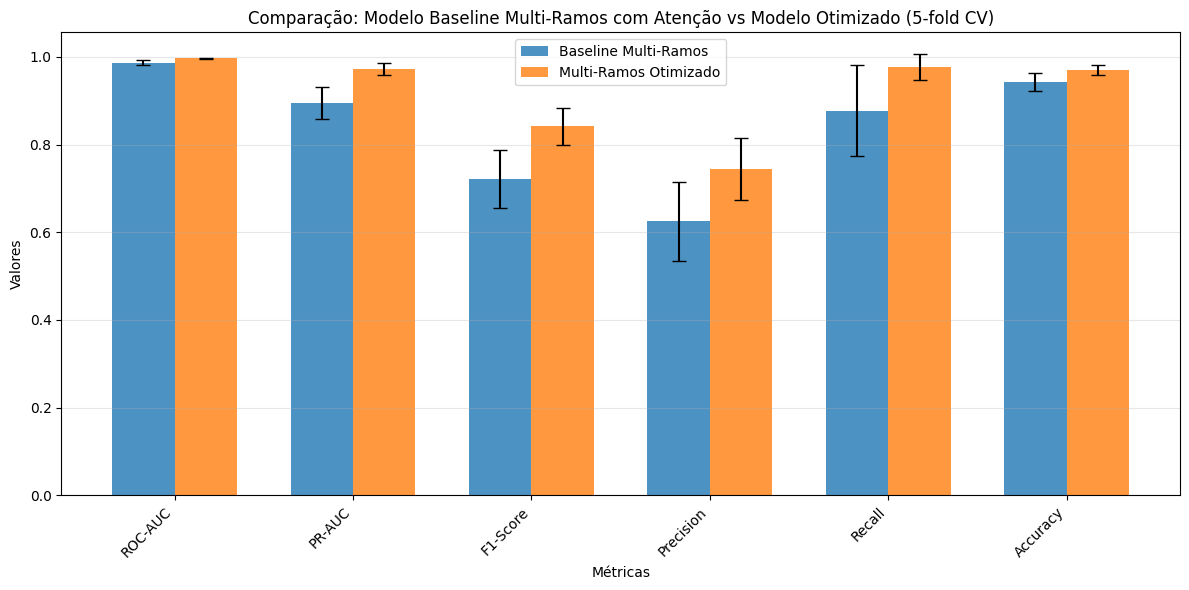

In [21]:
# Comparação entre modelo baseline e modelo otimizado
print("=== Comparação: Baseline Multi-Ramos com Atenção vs Otimizado ===\n")

comparison_df = pd.DataFrame({
    'Métrica': ['ROC-AUC', 'PR-AUC', 'F1-Score', 'Precision', 'Recall', 'Accuracy'],
    'Baseline (Mean)': [
        np.mean(metrics['roc_auc']),
        np.mean(metrics['pr_auc']),
        np.mean(metrics['f1']),
        np.mean(metrics['precision']),
        np.mean(metrics['recall']),
        np.mean(metrics['accuracy'])
    ],
    'Baseline (Std)': [
        np.std(metrics['roc_auc']),
        np.std(metrics['pr_auc']),
        np.std(metrics['f1']),
        np.std(metrics['precision']),
        np.std(metrics['recall']),
        np.std(metrics['accuracy'])
    ],
    'Otimizado (Mean)': [
        np.mean(optimized_metrics['roc_auc']),
        np.mean(optimized_metrics['pr_auc']),
        np.mean(optimized_metrics['f1']),
        np.mean(optimized_metrics['precision']),
        np.mean(optimized_metrics['recall']),
        np.mean(optimized_metrics['accuracy'])
    ],
    'Otimizado (Std)': [
        np.std(optimized_metrics['roc_auc']),
        np.std(optimized_metrics['pr_auc']),
        np.std(optimized_metrics['f1']),
        np.std(optimized_metrics['precision']),
        np.std(optimized_metrics['recall']),
        np.std(optimized_metrics['accuracy'])
    ]
})

comparison_df['Melhoria (%)'] = ((comparison_df['Otimizado (Mean)'] - comparison_df['Baseline (Mean)']) / comparison_df['Baseline (Mean)'] * 100).round(2)

print(comparison_df.to_string(index=False))

# Visualizar comparação
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df['Métrica']))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Baseline (Mean)'], width, 
               yerr=comparison_df['Baseline (Std)'], label='Baseline Multi-Ramos', capsize=5, alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['Otimizado (Mean)'], width,
               yerr=comparison_df['Otimizado (Std)'], label='Multi-Ramos Otimizado', capsize=5, alpha=0.8)

ax.set_xlabel('Métricas')
ax.set_ylabel('Valores')
ax.set_title('Comparação: Modelo Baseline Multi-Ramos com Atenção vs Modelo Otimizado (5-fold CV)')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Métrica'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()